In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
import warnings
warnings.filterwarnings(action='ignore')

In [40]:
!pip install xgboost

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [41]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")

In [42]:
# Construct Target by adding salary and bonus. 
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)
df.head()

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
3,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0
4,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",29,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Age                                                     1226 non-null   float64
 1   Gender                                                  1243 non-null   object 
 2   City                                                    1253 non-null   object 
 3   Position                                                1247 non-null   object 
 4   Total years of experience                               1237 non-null   object 
 5   Years of experience in Germany                          1221 non-null   object 
 6   Seniority level                                         1241 non-null   object 
 7   Your main technology / programming language             1126 non-null   object 
 8   Other technologies/programming languag

In [44]:
def get_missing_values(c_df):
    
    values = c_df.isnull().sum()
    percentage = 100 * c_df.isnull().sum() / len(c_df)
    table = pd.concat([values, percentage.round(2)], axis=1)
    table.columns = ['No of missing values', '% of missing values']
    
    return table[table['No of missing values'] != 0].sort_values('% of missing values', ascending = False).style.background_gradient('Greens')
get_missing_values(df)

,No of missing values,% of missing values
Other technologies/programming languages you use often,157,12.530000
Your main technology / programming language,127,10.140000
Number of vacation days,68,5.430000
Years of experience in Germany,32,2.550000
Сontract duration,29,2.310000
Age,27,2.150000
Company type,25,2.000000
Company size,18,1.440000
Employment status,17,1.360000
Total years of experience,16,1.280000


<AxesSubplot:xlabel='Years of experience in Germany'>

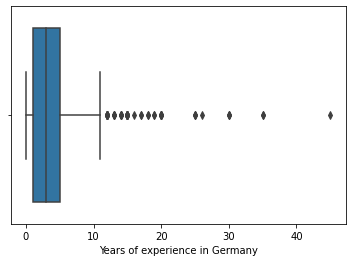

In [45]:
#changing type & getting box plot
df['Years of experience in Germany'].dropna()
df['Years of experience in Germany'] = pd.to_numeric(df['Years of experience in Germany'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
sns.boxplot(df['Years of experience in Germany'])

<AxesSubplot:xlabel='Total years of experience'>

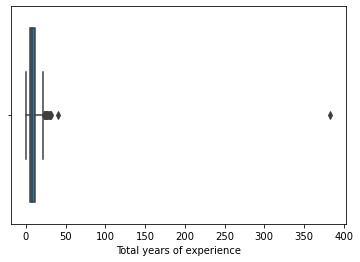

In [46]:
#changing column type 
df['Total years of experience'].dropna()
df['Total years of experience'] = pd.to_numeric(df['Total years of experience'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
sns.boxplot(df['Total years of experience'])

<AxesSubplot:xlabel='VacationDays'>

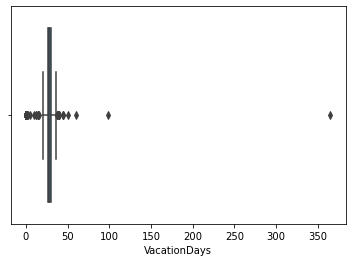

In [47]:
#changing column type Number of Vacation days to VacationDays and type to numeric 
df['Number of vacation days'].dropna()
df['VacationDays'] = pd.to_numeric(df['Number of vacation days'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
sns.boxplot(df['VacationDays'])

In [48]:
#removing outliers 
df=df[df['VacationDays']<35]
df=df[(20<df['Age'] )& (df['Age']<=50)]
df=df[df['Total years of experience']<30]
df=df[df['Years of experience in Germany']<20]


In [49]:
#for col in df.columns:
    #print(col)
    #print(df[col].value_counts().any() and df[col].value_counts())
    #print('--------------------------------------')
#output is large if want to check,please uncomment

In [50]:
#spelling check
SeniorityLevel = df['Seniority level']
df['Seniority level'].replace({'Working Student': 'Student','Intern':'Student','student':'Student','intern':'Student'},inplace=True)
df['Seniority level'].replace({'no idea, there are no ranges in the firm ':'Others'},inplace=True)
df['Seniority level'].replace({'No level':'Others','No level ':'Others','Key':'Others','Self employed':'Others'},inplace=True)
df['Seniority level'].replace({'Entry level':'Junior'},inplace=True)
df['Seniority level'].replace({'C-Level': 'Manager','C-level executive manager': 'Manager','Work Center Manager': 'Manager'},inplace=True)
df['Seniority level'].value_counts()

Senior       533
Middle       349
Lead         149
Junior        79
Head          38
Student        5
Others         4
Manager        4
Principal      3
VP             1
CTO            1
Director       1
Name: Seniority level, dtype: int64

In [51]:
#regrouping
df['Employment status'].replace({'Full-time employee': 'Full-time'},inplace=True)
df['Employment status'].replace({'Full-time position, part-time position, & self-employed (freelancing, tutoring)':'Full-time'},inplace=True)
df['Employment status'].replace({'Intern':'Student','Werkstudent':'Student','Werkstudent':'Student','Working Student':'Student','Working student':'Student',
'working student':'Student'},inplace=True)
df['Employment status'].replace({"full-time, but 32 hours per week (it was my request, I'm a student)":'Full-time'},inplace=True)
df['Employment status'].replace({'Part-time employee':'Part-time'},inplace=True)
df['Employment status'].replace({'Founder':'Director','Company Director':'Director'},inplace=True)
df['Employment status'].replace({'Self-employed (freelancer)':'Freelancer'},inplace=True)
df['Employment status'].value_counts()

Full-time     1130
Freelancer      20
Part-time        7
Student          4
Director         3
Name: Employment status, dtype: int64

In [52]:
#spelling,regrouping

df['Main language at work'].replace({'Russian, English':'English','Deuglisch':'English','English and German': 'English'}, inplace=True)
df['Main language at work'].add('Gemrman')
df['Main language at work'].replace({'Русский':'Russian'}, inplace=True)
# drop row with name '50/50' and both
df = df[df['Main language at work'] != '50/50']
df = df[df['Main language at work'] != 'both']
df['Main language at work'].value_counts()

English    975
German     162
Russian     14
Italian      3
Spanish      3
Polish       2
Czech        2
French       1
Name: Main language at work, dtype: int64

In [53]:
#value counts 
df['Company type'].value_counts()

Product                                                                     713
Startup                                                                     246
Consulting / Agency                                                         129
Bank                                                                          5
Media                                                                         3
E-commerce                                                                    3
University                                                                    2
Corporation                                                                   2
Research                                                                      2
Fintech                                                                       2
Handel                                                                        1
Institute                                                                     1
Semiconductor                           

In [54]:
#defining a function to categorize less frequent values as others
def replace_low_freq(d, col, threshold, replacement='other'):
    value_counts = d[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    tmp = d[col].replace(to_replace=to_remove, value=replacement)
    return tmp

In [55]:
#categorizing cities having less than 10 responses as others
df["City"] = replace_low_freq(df, "City", 10, "Other")
df["City"].value_counts()

Berlin       639
Munich       221
Other        197
Frankfurt     40
Hamburg       38
Stuttgart     22
Cologne       16
Name: City, dtype: int64

In [56]:
#categorizing less than 3 company types as others
df["Company type"] = replace_low_freq(df, "Company type", 3, "Other")
df["Company type"].value_counts()

Product                713
Startup                246
Consulting / Agency    129
Other                   64
Bank                     5
Name: Company type, dtype: int64

In [57]:
#checking value counts for this columns seems fine
df['Сontract duration']=df['Сontract duration'].drop(0)
df = df[df['Сontract duration'] != '0']
df['Сontract duration'].value_counts()

Unlimited contract    1095
Temporary contract      56
Name: Сontract duration, dtype: int64

In [58]:
#Categorizing values that are less than 5 as others
df["Position "] = replace_low_freq(df, "Position ", 5, "Other")
df['Position '].value_counts()

Software Engineer      357
Backend Developer      169
Other                  156
Data Scientist         105
Frontend Developer      82
QA Engineer             69
DevOps                  52
Mobile Developer        49
ML Engineer             38
Product Manager         37
Data Engineer           24
Designer (UI/UX)        16
Engineering Manager      8
Data Analyst             8
Name: Position , dtype: int64

<AxesSubplot:>

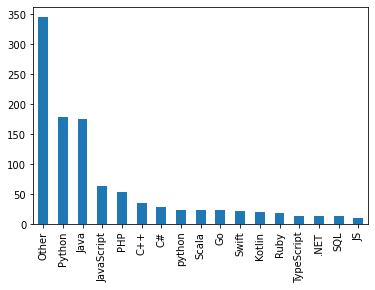

In [59]:
#categorizing less than 10 used languages as others
df["Your main technology / programming language"].replace({"Javascript": "JavaScript", "Python ":"Python"}, inplace=True)
df["Your main technology / programming language"] = replace_low_freq(df, "Your main technology / programming language", 10, "Other")
df["Your main technology / programming language"].value_counts().plot(kind='bar')

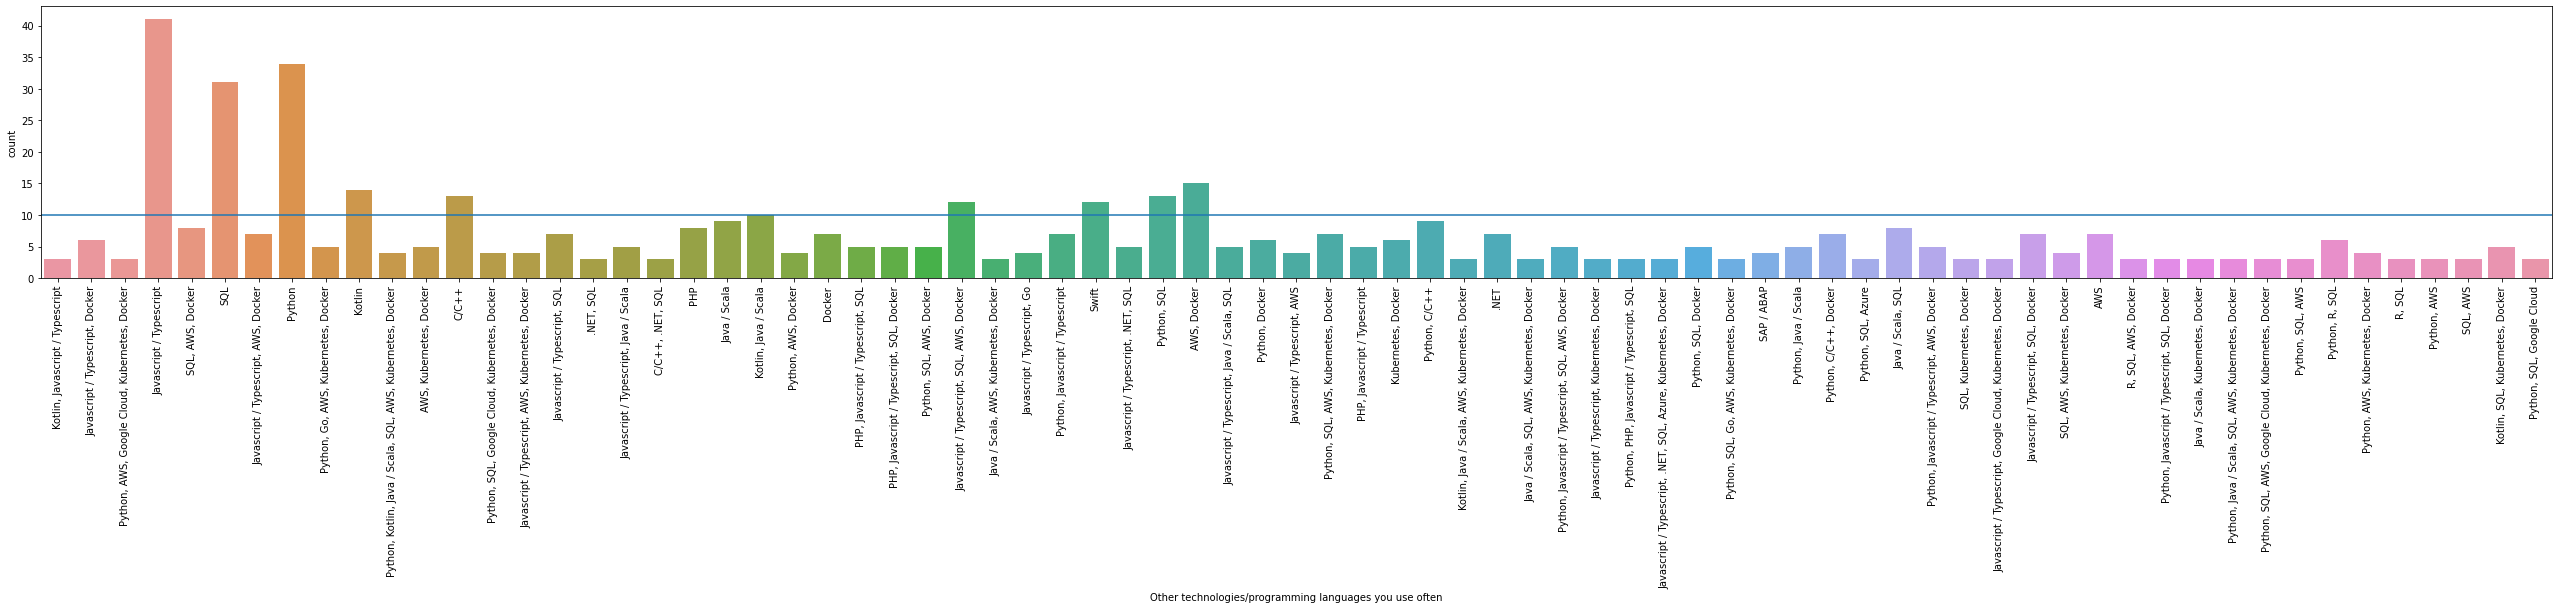

In [60]:
# Construct a temporary dataset with things that have > 2 records
# remove outliers
df_tmp = df[df.groupby("Other technologies/programming languages you use often")["Other technologies/programming languages you use often"].transform('size') > 2]
df_tmp = df_tmp[df_tmp["target"] < 250000]

plt.figure(figsize=(45,5))
ax = sns.countplot(x="Other technologies/programming languages you use often", data=df_tmp)
ax.axhline(10)
ax.tick_params(axis='x', rotation=90)


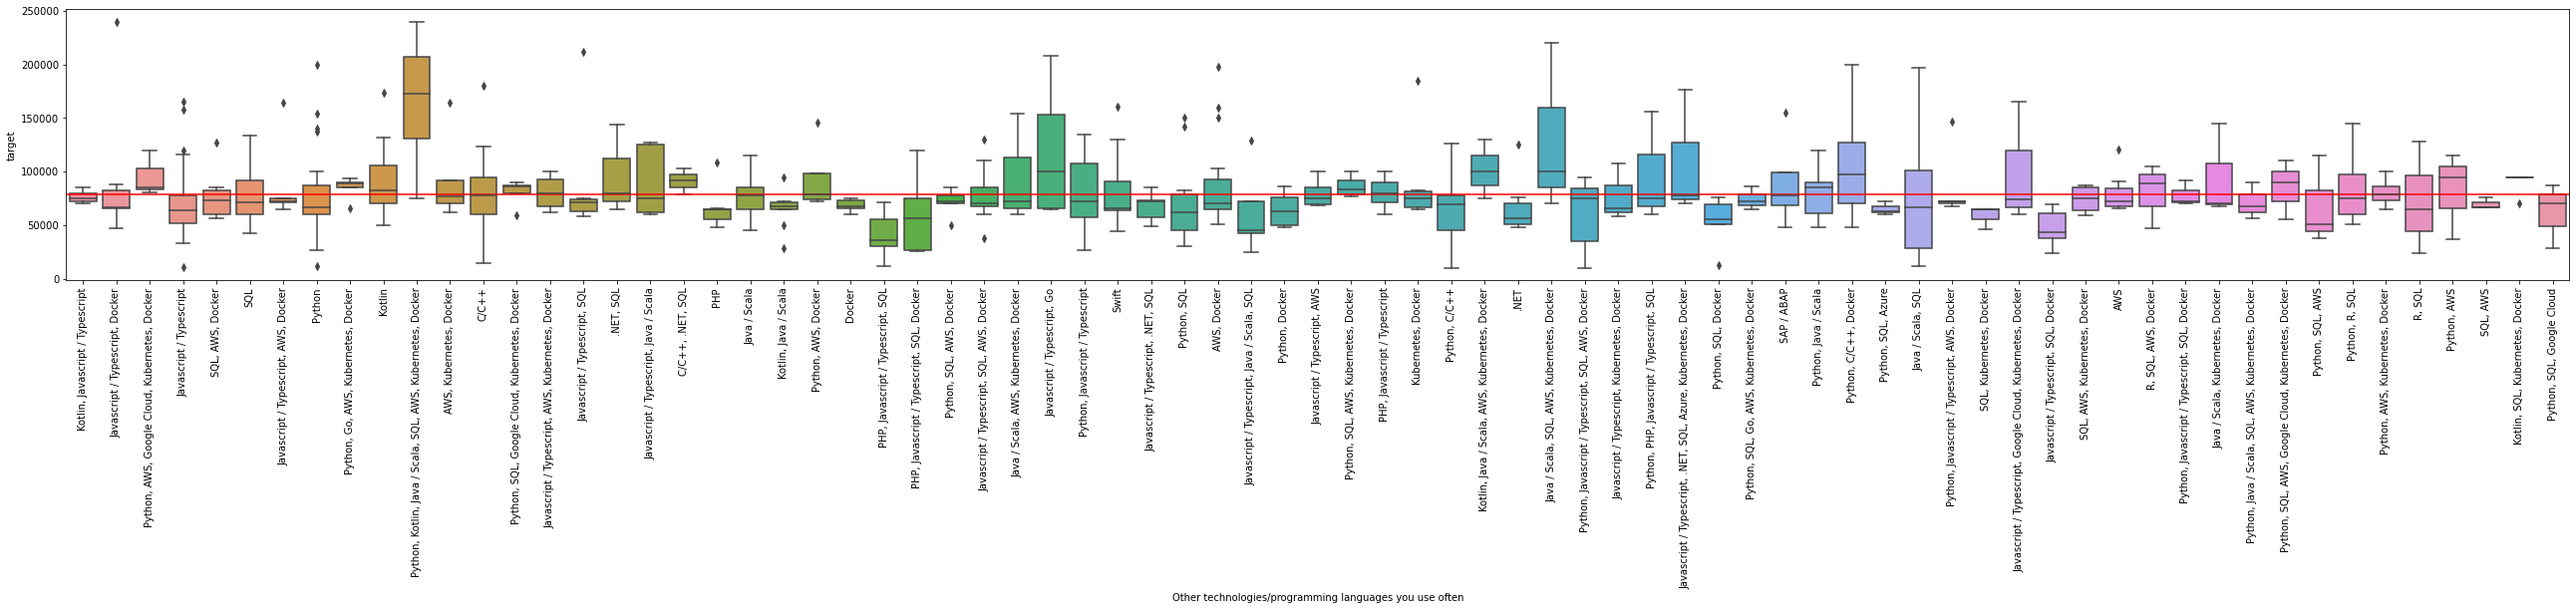

In [61]:
plt.figure(figsize=(45,5))
ax = sns.boxplot(x="Other technologies/programming languages you use often", y="target", data=df_tmp)
ax.axhline(df_tmp["target"].mean(), color="red")
ax.tick_params(axis='x', rotation=90)

In [62]:
#categorizing less than 10 used languages as others
df["Other technologies/programming languages you use often"].replace({"Javascript": "JavaScript", "Python ":"Python"}, inplace=True)
df["Other technologies/programming languages you use often"].replace({'typescript':'TypeScript','Typescript':'TypeScript','javascript':'JavaScript'},inplace=True)
df["Other technologies/programming languages you use often"].replace({'Php':'PHP','php':'PHP','Javascript / Typescript': 'TypeScript','JS':'JavaScript'},inplace=True)
df["Other technologies/programming languages you use often"] = replace_low_freq(df, "Other technologies/programming languages you use often", 10, "Other")
df["Other technologies/programming languages you use often"].value_counts()

Other                                        844
TypeScript                                    41
Python                                        35
SQL                                           31
AWS, Docker                                   15
Kotlin                                        14
C/C++                                         13
Python, SQL                                   13
Javascript / Typescript, SQL, AWS, Docker     12
Swift                                         12
Name: Other technologies/programming languages you use often, dtype: int64

In [63]:
#Data split and categorical and numerical features
y= df["target"]
X = df.drop(columns={"target"})
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)
numeric_features = ['Age','VacationDays','Total years of experience', 'Years of experience in Germany']
numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())])

categorical_features =['Gender', 'City', 'Position ','Seniority level','Your main technology / programming language','Other technologies/programming languages you use often',
       'Number of vacation days', 'Employment status', 'Сontract duration','Main language at work', 'Company size', 'Company type']
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("encoder", OneHotEncoder(handle_unknown="ignore"))])
preprocessor = ColumnTransformer( remainder='drop',
        transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features), ])

In [64]:
# Define the models to evaluate
models = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', Lasso(max_iter=7600)),
    ('Ridge', Ridge(max_iter=7600)),
    ('Elastic Net', ElasticNet(max_iter=7600)),
    ('Random Forest', RandomForestRegressor()),
    ('SGD', SGDRegressor(max_iter=7500)),
    ('Extra Trees', ExtraTreesRegressor()),
    ('XGBoost', XGBRegressor(objective='reg:squarederror')),
    ('Gradient Boosting', GradientBoostingRegressor()),
]

# Evaluate models with r2
for name, model in models:
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('model',TransformedTargetRegressor(regressor= model,transformer=PowerTransformer()))
    ])
    pipe.fit(X_train, y_train)
    print("Training scores: ", name, pipe.score(X_train,y_train))
    print("Testing Score: ",name,  pipe.score(X_test,y_test))

Training scores:  Linear Regression 0.25505594729733494
Testing Score:  Linear Regression 0.13287960825334355
Training scores:  Lasso -0.02518321966823578
Testing Score:  Lasso -0.047568628497894005
Training scores:  Ridge 0.2316858504906374
Testing Score:  Ridge 0.1678075179647116
Training scores:  Elastic Net -0.02518321966823578
Testing Score:  Elastic Net -0.047568628497894005
Training scores:  Random Forest 0.7063959900078602
Testing Score:  Random Forest 0.2494211025971913
Training scores:  SGD 0.16475619418363496
Testing Score:  SGD 0.21779706168790813
Training scores:  Extra Trees 1.0
Testing Score:  Extra Trees -0.7186126088441867
Training scores:  XGBoost 0.9664580440532099
Testing Score:  XGBoost 0.20410952855912545
Training scores:  Gradient Boosting 0.4510890681060824
Testing Score:  Gradient Boosting 0.2382500325099569


In [65]:
#optimizing best model

# Define the best model pipeline
best_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    #('transformer', PowerTransformer()),
    ('model', GradientBoostingRegressor())])
# Define the grid of hyperparameters to search over
param_grid = {
    'model__min_samples_leaf': [2,3,4],
    #'model__min_samples_split': [3,5,6],
    'model__max_features': ['sqrt', 'log2'],
    #"model__n_estimators":[100,300,500],
    "model__max_depth":[3,4,5],
    "model__learning_rate":[0.01,0.05,0.2],
    "model__alpha":[0.1,0.5],
    #'model__subsample':[0.85,0.9]
    }
# Define the transformed target regressor with grid search pipeline
best_grid_search_pipeline = TransformedTargetRegressor(regressor=GridSearchCV((best_pipeline), 
                                                                                             param_grid=param_grid, cv=5, n_jobs=-1, 
                                                                                             scoring='r2'), 
                                                                                             transformer=PowerTransformer() )

# Train the model
best_grid_search_pipeline.fit(X_train, y_train.ravel())
# Evaluate the model on the test set
testscore = best_grid_search_pipeline.score(X_test, y_test.ravel())
trainscore= best_grid_search_pipeline.score(X_train, y_train.ravel())
print(f"Test score: {testscore:.3f}")
print(f"Train score:{trainscore:.3f}")
y_pred = best_grid_search_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Test RMSE:', rmse)


Test score: 0.260
Train score:0.293
Test RMSE: 30367.54223773475


In [66]:
#feature selection using Recursive feature elimination 30 features selected
from sklearn.feature_selection import RFE
est = GradientBoostingRegressor()
rfe = RFE(estimator=est, n_features_to_select=30, step=1)
x_reg_dum = pd.get_dummies(X, drop_first=True)
rfe.fit(x_reg_dum, y)
print(rfe.ranking_)
mask = rfe.get_support()
new_features = x_reg_dum.columns[mask]
print(new_features)
Xreg_train, Xreg_test, yreg_train, yreg_test = train_test_split(x_reg_dum, y)
print("Test Score after feature Selection using RFE",rfe.score(Xreg_test,yreg_test))
yreg_pred = rfe.predict(Xreg_test)
reg_mse = mean_squared_error(yreg_test, yreg_pred)
reg_rmse = np.sqrt(mse)

print('test regression RMSE:', reg_rmse)

[ 1  1  1  1  1  8  5  1 51  1  1 48 10  1  1 24 22 72 36 17 47 27  1 13
 42 81  1  9  1  1  1 56 38  1 43 62 71  1 11 67 65 19  1 26 12  6 69 14
  1 84  1 44 34 39 77  1 15 16 30 33 58 40 31 64 46  1  3 59 32 35 73 41
 83 37 82  1 80  1 29 21 68 78 75 74 20 63 54 76 61 66  7 52 50  1 25 45
 60  1  1 53 49 57 55 23 79  1  1  1  2 18  4 28 70]
Index(['Age', 'Total years of experience', 'Years of experience in Germany',
       'VacationDays', 'Gender_Female', 'City_Frankfurt', 'City_Munich',
       'City_Other', 'Position _Data Engineer', 'Position _Data Scientist',
       'Position _Product Manager', 'Seniority level_Head',
       'Seniority level_Lead', 'Seniority level_Manager',
       'Seniority level_Middle', 'Seniority level_Senior',
       'Your main technology / programming language_C++',
       'Your main technology / programming language_Kotlin',
       'Your main technology / programming language_Scala',
       'Your main technology / programming language_TypeScript',
       '

cross_val, mean r2 score:  0.02 , same as RFECV score with all features
no of feat:  49
Optimal number of features : 49


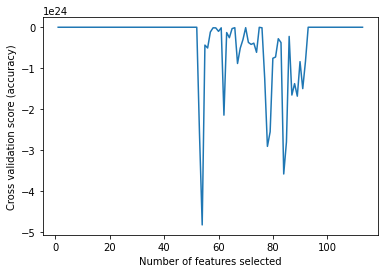

Test Score after feature Selection 0.3491694376613794
test RMSE with rfecv 30367.54223773475


In [75]:
#feature selection using recursive feature elimination cross validation
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score


class myestimator(TransformedTargetRegressor):

    def __init__(self,**kwargs):
        super().__init__()

    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)  
        self.coef_ = self.regressor_.coef_
        return self
x_reg_dum = pd.get_dummies(X, drop_first=True)
estimator = myestimator(regressor=best_grid_search_pipeline)
min_features_to_select=1
selector = RFECV(estimator, step=1, cv=3, scoring='r2')
selector = selector.fit(x_reg_dum, y)
#print("RFECV, r2 scores: ", np.round(selector.grid_scores_,2))
scores = cross_val_score(estimator, x_reg_dum, y, cv=5)
print("cross_val, mean r2 score: ", round(np.mean(scores),2), ", same as RFECV score with all features") 
print("no of feat: ", selector.n_features_ )
print("Optimal number of features : %d" %selector.n_features_)
mask = selector.support_
new_features = x_reg_dum.columns[mask]
#print(new_features)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_["mean_test_score"]) + min_features_to_select),
    selector.cv_results_["mean_test_score"],
)
plt.show()
Xreg_train, Xreg_test, yreg_train, yreg_test = train_test_split(x_reg_dum, y)
print("Test Score after feature Selection",selector.score(Xreg_test,yreg_test))
yreg_pred = selector.predict(Xreg_test)
reg_mse = mean_squared_error(yreg_test, yreg_pred)
reg_rmse = np.sqrt(mse)
print("test RMSE with rfecv",reg_rmse)


# Answers and Explainations
### Data Preparation
<li>Removed outliers from age, vacation day,experience years,experience in Germany columns & changed them to numeric type.
<li>For values that are less common in Cities where no.of respondents are less than 5 & count of company type are less than 3 are categorized as others.Same approach was applied for columns company type,programming alnguages,other programming alnguages etc.
<li> Treated the different labels that have same meaning in columns seniority level,employment status,main languages at work.
<li>Handled  missing values using Imputer


### Results
<li>before data cleaning-- testing score-0.06
<li>after data cleaning ---0.23
<li>after hyperparameter tuning(without feature selection)---0.26
<li>after feature selection---Using gradient boosting regressor and selecting feature by recursive feature elimination (setting mininmum features to 30 )---0.62
<li>feature selection using recursive feature elimination cross validation --0.35

### Choosing a regression model 
<li>defined a list of models to evaluate (linear regression, decision tree regression, random forest regression, and gradient boosting regression,lasso,ridge,xgboost,extratree,gradient boosting,transformed target) and used for loop to  evaluate their performance(r2) & chose transformed Target( regressor= random forest)
<li>used transformed target as target was right skewed observed from histplot

### Feature Selection Activities
<li>On using feature selection using recursive feature elimination using gradient boosting regressor, observed that on decreasing number of features, accuraccy increased, as with 25 features r2 was 0.80 ,with 35 r2 dropped to 0.45 i selected 30 and r2 was 0.62.But, this could lead to removal of importance features 
<li>also tried rfecv method by created a class Transformed target regressor and using gradient boosting regressor and optimal features i got were 49,but accuraccy was 0.35

### Hyperparameter Changes
<li> To deal with convergence warnings,tried a bunch of values for maximum iterations and set to 7000 to get rid of these warnings.
<li>tried various learning rates upto 100 but observed  with smaller learning rate there was less difference in train and test score ,so decide to go upto 0.2.
<li>tried a bunch of values for number of trees but takes a long time specially with large number of trees ,so not using it 
<li>increasing max depth reduced efficiency,so decided to chose upto 5.
<li>tried various values for subsample,but changing it does not affect much on efficiency but increase time so going with default value.
<li>smaller alpha values like 0.01 takes larger time (upto 2 mins )(not much improvement in scores),so decided to go with values from 0.1 to 1.0